# Exercise 3
### Anton Wiehe & Angelie Kraftelie

In [2]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Test image
im_frame = Image.open("positives/" + 'p01.png')
np_frame = np.array(im_frame.getdata())

# Load images (30, 573, 3) == (num_images, num_pixels, rgb)
n = 30
positives = np.zeros((n, 576, 3))
for i in range(n):
    im_frame = Image.open("positives/" + 'p' + ('0' if (i+1) < 10 else '') + str(i + 1) + '.png')
    positives[i] = np.array(im_frame.getdata())
    
negatives = np.zeros((n, 576, 3))
for i in range(n):
    im_frame = Image.open("negatives/" + 'n' + ('0' if (i+1) < 10 else '') + str(i + 1) + '.png')
    negatives[i] = np.array(im_frame.getdata())

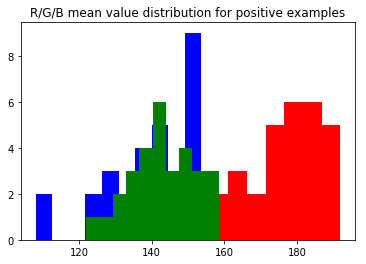

In [3]:
red_pos = positives[:, :, 0]
green_pos = positives[:, :, 1]
blue_pos = positives[:, :, 2]

red_mean_pos = np.mean(red_pos, axis=1)
blue_mean_pos = np.mean(green_pos, axis=1)
green_mean_pos = np.mean(blue_pos, axis=1)

plt.hist(red_mean_pos, color="red")
plt.hist(blue_mean_pos, color="blue")
plt.hist(green_mean_pos, color="green")
plt.title("R/G/B mean value distribution for positive examples")
plt.show()


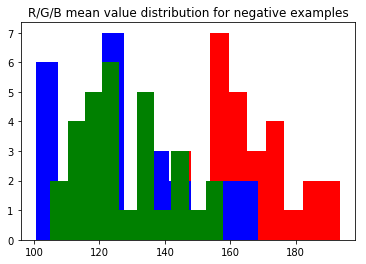

In [4]:
red_neg = negatives[:, :, 0]
green_neg = negatives[:, :, 1]
blue_neg = negatives[:, :, 2]

red_mean_neg = np.mean(red_neg, axis=1)
blue_mean_neg = np.mean(green_neg, axis=1)
green_mean_neg = np.mean(blue_neg, axis=1)

plt.hist(red_mean_neg, color="red")
plt.hist(blue_mean_neg, color="blue")
plt.hist(green_mean_neg, color="green")
plt.title("R/G/B mean value distribution for negative examples")
plt.show()

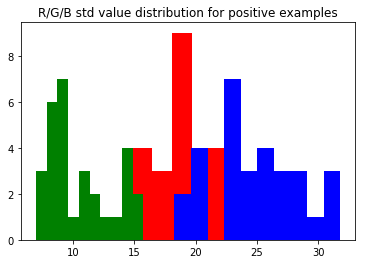

In [5]:
red_std_pos = np.std(red_pos, axis=1)
blue_std_pos = np.std(green_pos, axis=1)
green_std_pos = np.std(blue_pos, axis=1)

plt.hist(red_std_pos, color="red")
plt.hist(blue_std_pos, color="blue")
plt.hist(green_std_pos, color="green")
plt.title("R/G/B std value distribution for positive examples")
plt.show()

(30,)
(30,)


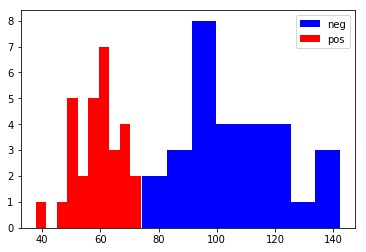

In [10]:
red_std_neg = np.std(red_neg, axis=1)
blue_std_neg = np.std(green_neg, axis=1)
green_std_neg = np.std(blue_neg, axis=1)


max_five_pixels_red_pos = np.mean(np.sort(red_pos, axis=1)[:, :5], axis=1)
max_five_pixels_blue_pos = np.mean(np.sort(blue_pos, axis=1)[:, :5], axis=1)
max_five_pixels_green_pos = np.mean(np.sort(green_pos, axis=1)[:, :5], axis=1)

max_five_pixels_red_neg = np.mean(np.sort(red_neg, axis=1)[:, :5], axis=1)
max_five_pixels_blue_neg = np.mean(np.sort(blue_neg, axis=1)[:, :5], axis=1)
max_five_pixels_green_neg = np.mean(np.sort(green_neg, axis=1)[:, :5], axis=1)

#plt.hist(red_std_neg, color="red")
#plt.hist(blue_std_neg, color="blue")
#plt.hist(green_std_neg, color="green")
#plt.title("R/G/B std value distribution for negative examples")
#plt.show()

print(np.shape(red_std_neg))
print(np.shape(max_five_pixels_red_neg))
plt.hist(max_five_pixels_green_neg, color="blue", label="neg")
plt.hist(max_five_pixels_green_pos, color="red", label="pos")
plt.legend()
plt.show()

In [11]:
pos_features = np.concatenate([np.reshape(red_std_pos, (n, 1)),
                              np.reshape(blue_std_pos, (n, 1)), np.reshape(green_std_pos, (n, 1)), 
                              np.reshape(max_five_pixels_red_pos, (n, 1)), np.reshape(max_five_pixels_blue_pos, (n, 1))
                            , np.reshape(max_five_pixels_green_pos, (n, 1))], axis=1)
neg_features = np.concatenate([np.reshape(red_std_neg, (n, 1)),
                              np.reshape(blue_std_neg, (n, 1)), np.reshape(green_std_neg, (n, 1)), 
                              np.reshape(max_five_pixels_red_neg, (n, 1)), np.reshape(max_five_pixels_blue_neg, (n, 1))
                            , np.reshape(max_five_pixels_green_neg, (n, 1))], axis=1)
num_features = np.shape(pos_features)[1]
np.shape(pos_features)

(30, 6)

In [12]:
def split_test_train(features_0, features_1):
    test_split_percentage = 0.05
    number_of_tests = int(n * 2 * 0.1)

    test_idxs = np.random.randint(0, n * 2, number_of_tests)
    both = np.concatenate((features_0, features_1), axis=0)
    test_features = both[test_idxs,:]
    test_labels = (test_idxs >= 30)

    #print("Test idxs: ", test_idxs)
    idxs_0 = test_idxs[test_idxs < n]
    idxs_1 = test_idxs[test_idxs >= n] - n

    features_0 = np.delete(features_0, idxs_0, axis=0)
    features_1 = np.delete(features_1, idxs_1, axis=0)
    
    return features_0, features_1, test_features, test_labels

In [13]:
# Shuffle two lists in same order
def shuffle(a,b):
    assert len(a) == len(b)
    idxs = np.arange(0, len(a), 1)
    np.random.shuffle(idxs)
    return a[idxs], b[idxs]

In [14]:
def k_fold(features_0, features_1, k=10):
    num_features = len(features_0[0])
    split_percentage = 1 / k
    samples_per_split = (len(features_0) + len(features_1)) // k
    both_features = np.concatenate((features_0, features_1), axis=0)
    both_labels = np.concatenate((np.zeros(len(features_0)), np.ones(len(features_1))), axis=0)
    splits = np.zeros((k, samples_per_split, num_features))
    splits_labels = np.zeros((k, samples_per_split))
    for i in range(k):
        split_idxs = np.random.randint(0, len(both_features), samples_per_split)
        split_labels = both_labels[split_idxs]
        split = both_features[split_idxs]

        splits[i] = split
        splits_labels[i] = split_labels

        both_labels = np.delete(both_labels, split_idxs, axis=0)
        both_features = np.delete(both_features, split_idxs, axis=0)

    return splits, splits_labels
    

In [15]:
def evaluate_k_fold(splits, split_labels):
    train_accuracies = np.zeros(len(splits))
    test_accuracies = np.zeros(len(splits))
    
    train_accuracies = []
    test_accuracies = []
    for i in range(len(splits)):
        features = np.concatenate((splits[0:i], splits[i + 1:]), axis=0)
        labels = np.concatenate((split_labels[0:i], split_labels[i + 1:]), axis=0)
        test_features = splits[i]
        test_labels = split_labels[i]
        features_0 = features[labels == 0]
        features_1 = features[labels == 1]
        
        #print(np.shape(splits))
        #print(np.shape(split_labels))
        features = np.reshape(features, ((len(features) * len(features[0]), len(features[0][0]))))
        labels = np.reshape(labels, (len(labels) * len(labels[0])))

        
        test_accuracy = train_and_test(features_0, features_1, test_features, test_labels)
        test_accuracies.append(test_accuracy)
        train_accuracy = train_and_test(features_0, features_1, features, labels)
        train_accuracies.append(train_accuracy)
        
        #print("Split ", i ,)
        #print(" Test Accuracy: ", test_accuracy)
        #print(" Train Accuracy: ", train_accuracy)
        #print()
        
    return np.mean(train_accuracies), np.mean(test_accuracies)
        

In [24]:
folds, labels = k_fold(pos_features, neg_features, 2)
#folds
train, test = evaluate_k_fold(folds, labels)
#print("Overall train - test accuracy: ", train, test)
#train_and_test(pos_features, neg_features, np.concatenate((pos_features, neg_features)), np.concatenate((np.zeros(30), np.ones(30))))

Parameters:
phi:  0.8
mu_0:  [ 19.38541321  24.84986984  10.50157667 106.         108.77333333
  58.96      ]
mu_1:  [  9.15690078   9.9563192    8.52678672 141.47333333 105.81333333
 104.33333333]
sigma:  [[ 11.96119416  12.41573794   4.78475766 -28.00904557 -15.92611044
  -28.2439644 ]
 [ 12.41573794  16.80342623   6.84672572 -20.06133104 -11.73869699
  -28.28315415]
 [  4.78475766   6.84672572   7.09125098  -1.35808096 -18.47051778
  -12.18697228]
 [-28.00904557 -20.06133104  -1.35808096 223.13264444  99.10617778
  165.98711111]
 [-15.92611044 -11.73869699 -18.47051778  99.10617778 179.99022222
  132.57991111]
 [-28.2439644  -28.28315415 -12.18697228 165.98711111 132.57991111
  207.00231111]]
Difficult features:  [ 18.17166593  24.91023598   7.91387907 107.         114.8
  57.4       ]
Parameters:
phi:  0.8
mu_0:  [ 19.38541321  24.84986984  10.50157667 106.         108.77333333
  58.96      ]
mu_1:  [  9.15690078   9.9563192    8.52678672 141.47333333 105.81333333
 104.33333333]
si

In [17]:
# Calculate Parameters:
def calculate_parameters(features_0, features_1):
    phi = len(features_0) / (len(features_0) + len(features_1))
    mu_0 = np.mean(pos_features, axis=0)
    mu_1 = np.mean(neg_features, axis=0)
    #temp_0 = (pos_features - mu_0) @ (pos_features - mu_0)
    temp_0 = np.array([np.reshape((feature_vec - mu_0), (num_features, 1)) @ np.reshape(feature_vec - mu_0, (1, num_features)) for feature_vec in pos_features])
    #temp_1 = (neg_features - mu_1) @ (neg_features - mu_1)
    temp_1 = np.array([(feature_vec - mu_1).reshape(num_features, 1) @ (feature_vec - mu_1).reshape(1, num_features) for feature_vec in neg_features])

    sigma = np.mean(np.concatenate([temp_0, temp_1], axis=0), axis=0)
    print("Parameters:")
    print("phi: ", phi)
    print("mu_0: ", mu_0)
    print("mu_1: ", mu_1)
    print("sigma: ", sigma)
    return phi, mu_0, mu_1, sigma

In [18]:
#print(sigma)
#print(np.shape(np.concatenate([temp_0, temp_1])))
#print(np.shape(sigma))


In [19]:
def likelihood(x, mu, sigma):
    n_umberOfFeatures = len(mu)
    n = n_umberOfFeatures
    denominator = ((2 * np.pi) ** (n / 2) * np.linalg.det(sigma) ** (1/2))
    #print("determinant", np.linalg.det(sigma))
    #print("Denominator: ", denominator)
    nominator = np.exp(-(1/2) * np.transpose(x - mu) @ np.linalg.inv(sigma) @ (x - mu))
    #print("Nominator: ", nominator)
    return nominator / denominator

In [20]:
def classify(x, phi, mu_0, mu_1, sigma):
    prob_0 = likelihood(x, mu_0, sigma) * phi
    prob_1 = likelihood(x, mu_1, sigma) * (1 - phi)
    
    #print("Prob 0: ", prob_0)
    #print("Prob 1: ", prob_1)
    #print("Ratio:", prob_0 / prob_1)
    if prob_0 > prob_1:
        #print("Predicted: 0 - positive")
        return 0
    else:
        #print("Predicted: 1 - negative")
        return 1

In [21]:
def train_and_test(features_0, features_1, test_features, test_labels):
    phi, mu_0, mu_1, sigma = calculate_parameters(features_0, features_1)
    
    n_correct = 0
    for i in range(len(test_features)):
        correct = test_labels[i] == classify(test_features[i], phi, mu_0, mu_1, sigma)
        n_correct += correct
        if not correct:
            print("Difficult features: ", test_features[i])
    return n_correct / len(test_features) 
    

In [22]:
sample = pos_features[0]
neg_sample = neg_features[0]

correct = 0
for i in range(len(both)):
    sample = both[i]
    prediction = classify(sample, mu_0, mu_1, sigma)
    if prediction == 0 and i < 30 or prediction == 1 and i >= 30:
        correct += 1
        #print("Correct!")
        #print()
    else:
        #print("Wrong")
        print("Wrong idx: ", i)
        print()
print("Training Accuracy: ", round(correct / len(both) * 100, 2))

NameError: name 'both' is not defined

In [32]:
correct = 0
for i in range(len(test_features)):
    sample = neg_features[i]
    prediction = classify(sample, mu_0, mu_1, sigma)
    if prediction == test_labels[i]:
        correct += 1
    #print("Prediction: ", prediction)
    #print("Label: ", int(test_labels[i]))
    #print()
print("Test Accuracy: ", round(correct / len(test_features) * 100, 2))

NameError: name 'test_features' is not defined

In [33]:
folds, labels = k_fold(pos_features, neg_features, 10)

In [ ]:
Features:
    
We used two functions applied to all three color channels to get six features. The first function is simply the standard deviation over all pixels. The second function is the mean of the five darkest pixels of the corresponding color channel.